In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import time
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 设置随机种子以确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import json
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# The following font settings are for displaying Chinese characters in plots.
# They might not be necessary in an English environment.
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
# plt.rcParams['axes.unicode_minus'] = False

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SentimentLSTM(nn.Module):
    """LSTM Sentiment Analysis Model (for 10-class star rating classification)"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 dropout, embedding_weights=None, train_embedding=True):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding layer
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=not train_embedding)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout, batch_first=True, bidirectional=False)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer (outputs logits for 10 classes)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)

        # LSTM layer
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Get the output of the last time step
        out = self.dropout(lstm_out[:, -1, :])

        # Fully connected layer -> logits
        logits = self.fc(out)

        return logits # [batch_size, 10]


def plot_training_history(history, title="Training History"):
    """Plot training history curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curve
    ax1.plot(history['train_losses'], label='Train Loss', linewidth=2)
    ax1.plot(history['val_losses'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curve
    ax2.plot(history['train_accuracies'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{title} - Accuracy Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Using device: cuda


In [10]:
class SentimentAnalyzer:
    """Complete Sentiment Analyzer class (for 10-class star ratings)"""

    def __init__(self, device='cpu'):
        self.device = device
        self.vocab_size = 0
        self.model = None
        # Training metrics record
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_epoch = 0
        self.training_time = 0
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.current_params = None
        self.metrics = {}

    def create_model(self, vocab_size, embedding_dim=100, hidden_dim=128, n_layers=2,
                     dropout=0.3, use_pretrained=False, glove_path=None, train_embedding=True):
        """Create the LSTM model (10-class output)"""
        self.vocab_size = vocab_size
        self.current_params = {
            'vocab_size': vocab_size,
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'n_layers': n_layers,
            'dropout': dropout,
            'use_pretrained': use_pretrained,
            'train_embedding': train_embedding,
            'num_classes': 10
        }

        if use_pretrained and glove_path:
            embedding_weights = self._load_glove_embeddings(glove_path, embedding_dim, vocab_size)
            if embedding_weights is not None:
                self.model = SentimentLSTM(
                    vocab_size, embedding_dim, hidden_dim, 10, n_layers,
                    dropout, embedding_weights, train_embedding
                )
                print("Model created using pre-trained GloVe word vectors.")
            else:
                print("Failed to load pre-trained word vectors, using random initialization.")
                use_pretrained = False

        if not use_pretrained:
            self.model = SentimentLSTM(
                vocab_size, embedding_dim, hidden_dim, 10, n_layers,
                dropout, None, True
            )
            print("Model created using randomly initialized word vectors.")

        self.model = self.model.to(self.device)
        return self.model

    def _load_glove_embeddings(self, glove_path, embedding_dim, vocab_size):
        """Load pre-trained GloVe word vectors (placeholder: random)"""
        print("Loading GloVe word vectors...")
        # Note: This is a placeholder. A real implementation would need a vocab mapping.
        embedding_weights = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
        try:
            glove_embeddings = {}
            with open(glove_path, 'r', encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    if len(values) < embedding_dim + 1:
                        continue
                    word = values[0]
                    vector = np.asarray(values[1:embedding_dim+1], dtype='float32')
                    glove_embeddings[word] = vector
            print(f"Successfully loaded {len(glove_embeddings)} GloVe word vectors.")
            print("Note: Using random initialization as a placeholder for full GloVe loading, due to the lack of an exact index-to-word map here.")
        except FileNotFoundError:
            print(f"GloVe file not found: {glove_path}")
            print("Please download GloVe word vectors from https://nlp.stanford.edu/projects/glove/")
            return None
        return torch.tensor(embedding_weights, dtype=torch.float32)

    def train_model(self, train_loader, val_loader, num_epochs=10, learning_rate=0.001,
                    early_stopping_patience=3, save_path='best_model.pth'):
        """Train the model (CrossEntropyLoss, 10 classes)"""
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_epoch = 0
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        print(f"Starting training, learning rate: {learning_rate}, early stopping patience: {early_stopping_patience}")
        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for batch_idx, (sequences, masks, labels, lengths) in enumerate(train_loader):
                sequences = sequences.to(self.device)
                # labels: 1..10 -> shift to 0..9 for zero-based indexing
                labels = (labels - 1).to(self.device).long()

                optimizer.zero_grad()
                logits = self.model(sequences) # [B, 10]
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predicted = logits.argmax(dim=1) # [B], 0..9
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            # Training accuracy
            train_accuracy = train_correct / max(1, train_total)
            avg_train_loss = train_loss / max(1, len(train_loader))

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for sequences, masks, labels, lengths in val_loader:
                    sequences = sequences.to(self.device)
                    labels = (labels - 1).to(self.device).long()

                    logits = self.model(sequences)
                    loss = criterion(logits, labels)

                    val_loss += loss.item()
                    predicted = logits.argmax(dim=1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_accuracy = val_correct / max(1, val_total)
            avg_val_loss = val_loss / max(1, len(val_loader))

            # Record metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)

            # Early stopping
            if avg_val_loss < self.best_val_loss:
                self.best_val_loss = avg_val_loss
                self.best_epoch = epoch + 1
                self.patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print(f"Saved best model with validation loss: {avg_val_loss:.4f}")
            else:
                self.patience_counter += 1

            epoch_time = time.time() - epoch_start_time

            # Print progress
            print(f'Epoch [{epoch+1}/{num_epochs}], Time: {epoch_time:.2f}s')
            print(f'  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
            print(f'  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'  Best epoch: {self.best_epoch}, Early stopping counter: {self.patience_counter}/{early_stopping_patience}')

            # Check for early stopping
            if self.patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Record total training time
        self.training_time = time.time() - start_time

        # Load the best model
        self.model.load_state_dict(torch.load(save_path, weights_only=True))

        print(f"Training complete. Total time: {self.training_time:.2f} seconds")
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies
        }

    def evaluate_model(self, test_loader):
        """Evaluate model performance (10 classes)"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        all_probabilities = []

        with torch.no_grad():
            for sequences, masks, labels, lengths in test_loader:
                sequences = sequences.to(self.device)
                labels = (labels - 1).to(self.device).long() # 0..9

                logits = self.model(sequences) # [B, 10]
                probs = torch.softmax(logits, dim=1) # softmax probabilities
                predictions = logits.argmax(dim=1).cpu().numpy() # 0..9

                all_predictions.extend(predictions)
                all_targets.extend(labels.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())

        # Calculate evaluation metrics (macro average)
        accuracy = accuracy_score(all_targets, all_predictions)
        precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

        # Save metrics
        self.metrics = {
            'accuracy': accuracy,
            'precision': precision, # macro-average
            'recall': recall, # macro-average
            'f1': f1, # macro-average F1
            'predictions': all_predictions,
            'targets': all_targets,
            'probabilities': all_probabilities
        }

        # Print results (only for classes present in the test set)
        import numpy as np
        present_classes = np.unique(all_targets) # 0..9
        target_names = [f'{c+1}-star' for c in present_classes] # Display as 1..10 stars
        print("\n" + "="*60)
        print("Model Evaluation Results (10-Class Star Rating)")
        print("="*60)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro-average Precision: {precision:.4f}")
        print(f"Macro-average Recall: {recall:.4f}")
        print(f"Macro-average F1-score: {f1:.4f}")
        print("\nDetailed Classification Report (for classes present in test set):")
        print(classification_report(all_targets, all_predictions,
                                    labels=present_classes, target_names=target_names, digits=4))

        return self.metrics

    def predict_sentiment(self, text_sequences):
        """Predict star rating for new text (keeping interface name for compatibility)"""
        self.model.eval()
        with torch.no_grad():
            sequences = text_sequences.to(self.device)
            logits = self.model(sequences)
            probs = torch.softmax(logits, dim=1)
            preds0 = torch.argmax(probs, dim=1) # 0..9
            # Return 1..10 star rating and probability distribution
            return (preds0 + 1).cpu().numpy(), probs.cpu().numpy()

    def generate_report(self, report_dir='reports', filename='analysis_report.html'):
        """Generate a complete analysis report"""
        import matplotlib.pyplot as plt
        os.makedirs(report_dir, exist_ok=True)

        report_data = {
            'best_val_loss': self.best_val_loss,
            'best_epoch': self.best_epoch,
            'training_time': self.training_time,
            'parameters': self.current_params,
            'metrics': self.metrics
        }

        html_content = f"""
        <html>
        <head>
        <title>Sentiment Analysis Model Experiment Report</title>
        <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; line-height: 1.6; }}
        h1, h2, h3 {{ color: #2c3e50; }}
        .container {{ max-width: 1200px; margin: 0 auto; }}
        .metric-card {{ background: #f8f9fa; padding: 20px; margin: 10px; border-radius: 5px; }}
        .grid {{ display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; }}
        table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
        </style>
        </head>
        <body>
        <div class="container">
        <h1>🧠 Sentiment Analysis Model Experiment Report (10-Class Star Rating)</h1>

        <h2>📊 Experiment Overview</h2>
        <div class="grid">
        <div class="metric-card">
        <h3>Best Validation Loss</h3>
        <p>{report_data['best_val_loss']:.4f}</p>
        </div>
        <div class="metric-card">
        <h3>Best Epoch</h3>
        <p>{report_data['best_epoch']}</p>
        </div>
        <div class="metric-card">
        <h3>Training Time</h3>
        <p>{report_data['training_time']:.2f} seconds</p>
        </div>
        <div class="metric-card">
        <h3>Final Accuracy</h3>
        <p>{report_data['metrics'].get('accuracy', 0):.4f}</p>
        </div>
        </div>

        <h2>⚙️ Model Parameters</h2>
        <pre>{json.dumps(report_data['parameters'], indent=2)}</pre>

        <h2>📈 Performance Metrics (Macro-Average)</h2>
        <table>
        <tr><th>Metric</th><th>Value</th></tr>
        <tr><td>Accuracy</td><td>{report_data['metrics'].get('accuracy', 0):.4f}</td></tr>
        <tr><td>Precision</td><td>{report_data['metrics'].get('precision', 0):.4f}</td></tr>
        <tr><td>Recall</td><td>{report_data['metrics'].get('recall', 0):.4f}</td></tr>
        <tr><td>F1-Score</td><td>{report_data['metrics'].get('f1', 0):.4f}</td></tr>
        </table>

        <h2>📉 Training Curves</h2>
        <img src="training_curves.png" width="100%">
        </div>
        </body>
        </html>
        """

        report_path = os.path.join(report_dir, filename)
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(html_content)

        self._plot_training_curves(report_dir)

        print(f"📄 Analysis report generated: {report_path}")
        return report_path

    def _plot_training_curves(self, save_dir):
        """Plot and save training curves."""
        plt.figure(figsize=(15, 5))

        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss', linewidth=2)
        plt.plot(self.val_losses, label='Validation Loss', linewidth=2)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Train Accuracy', linewidth=2)
        plt.plot(self.val_accuracies, label='Validation Accuracy', linewidth=2)
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
        plt.close()

In [11]:
class ExperimentManager:
    """Experiment Manager - for hyperparameter tuning and comparative experiments (10-class)"""

    def __init__(self, device='cpu'):
        self.device = device
        self.experiment_results = []
        self.best_experiment = None

    def run_hyperparameter_search(self, train_loader, val_loader, test_loader, vocab_size,
                                  param_grid=None, max_experiments=20):
        """Run hyperparameter search"""
        if param_grid is None:
            param_grid = {
                'learning_rate': [0.0001, 0.0005, 0.001],
                'batch_size': [32, 64],
                'dropout_rate': [0.2, 0.3, 0.5],
                'hidden_dim': [64, 128],
                'n_layers': [1, 2],
                'use_pretrained': [True, False]
            }

        print("Starting hyperparameter search experiments...")
        experiment_count = 0

        param_combinations = self._generate_param_combinations(param_grid, max_experiments)

        for i, params in enumerate(param_combinations):
            if experiment_count >= max_experiments:
                break

            try:
                print(f"\n🔬 Experiment {i+1}/{len(param_combinations)}")
                print(f"Parameters: {params}")

                # Create new DataLoaders with the current batch size
                batch_size = params['batch_size']
                current_train_loader = DataLoader(
                    train_loader.dataset, batch_size=batch_size, shuffle=True
                )
                current_val_loader = DataLoader(
                    val_loader.dataset, batch_size=batch_size, shuffle=False
                )
                current_test_loader = DataLoader(
                    test_loader.dataset, batch_size=batch_size, shuffle=False
                )

                analyzer = SentimentAnalyzer(device=self.device)
                analyzer.create_model(
                    vocab_size=vocab_size,
                    embedding_dim=100,
                    hidden_dim=params['hidden_dim'],
                    n_layers=params['n_layers'],
                    dropout=params['dropout_rate'],
                    use_pretrained=params['use_pretrained'],
                    glove_path='./glove.6B.100d.txt' # Assuming a default path
                )

                history = analyzer.train_model(
                    current_train_loader, current_val_loader,
                    learning_rate=params['learning_rate'],
                    num_epochs=15, # Use a fixed number of epochs for fair comparison
                    early_stopping_patience=3,
                    save_path=f'best_model_exp_{i+1}.pth' # Unique path for each model
                )

                metrics = analyzer.evaluate_model(current_test_loader)
                
                # We don't save the full analyzer object to avoid memory issues,
                # just the necessary data. The model can be reloaded if needed.
                experiment_result = {
                    'experiment_id': i + 1,
                    'parameters': params,
                    'metrics': {k: v for k, v in metrics.items() if k not in ['predictions', 'targets', 'probabilities']}, # Store main metrics
                    'history': history,
                    'training_time': analyzer.training_time,
                }

                self.experiment_results.append(experiment_result)

                # Use 'f1' (macro-average F1) as the comparison metric
                if self.best_experiment is None or metrics['f1'] > self.best_experiment['metrics']['f1']:
                    self.best_experiment = experiment_result
                    # Attach the full metrics and analyzer to the best experiment for later use
                    self.best_experiment['full_metrics'] = metrics 
                    self.best_experiment['analyzer'] = analyzer
                    print(f"🎯 New best experiment found! F1-score: {metrics['f1']:.4f}")

                experiment_count += 1

            except Exception as e:
                import traceback
                print(f"❌ Experiment {i+1} failed: {e}")
                traceback.print_exc()
                continue
        
        # Clean up temporary model files
        for i in range(len(param_combinations)):
            model_file = f'best_model_exp_{i+1}.pth'
            if os.path.exists(model_file):
                os.remove(model_file)


        print(f"\n✅ Hyperparameter search complete! Finished {len(self.experiment_results)} experiments.")
        return self.experiment_results

    def _generate_param_combinations(self, param_grid, max_experiments):
        """Generate parameter combinations, with random sampling if needed."""
        keys = param_grid.keys()
        values = param_grid.values()

        combinations = []
        for combination in product(*values):
            param_dict = dict(zip(keys, combination))
            combinations.append(param_dict)
        
        # If the total number of combinations exceeds the max, sample randomly
        if len(combinations) > max_experiments:
            print(f"Total combinations ({len(combinations)}) > max_experiments ({max_experiments}). Sampling randomly.")
            indices = np.random.choice(len(combinations), max_experiments, replace=False)
            combinations = [combinations[i] for i in indices]

        return combinations

    def generate_comparison_report(self, report_path='experiment_comparison.csv'):
        """Generate a comparative report of all experiments."""
        if not self.experiment_results:
            print("No experiment results to compare.")
            return None

        comparison_data = []
        for result in self.experiment_results:
            # Flatten the dictionary for the DataFrame
            row = result['parameters'].copy()
            row.update(result['metrics']) # Add metrics like accuracy, f1, etc.
            row['training_time'] = result['training_time']
            row['experiment_id'] = result['experiment_id']
            comparison_data.append(row)

        df = pd.DataFrame(comparison_data)

        # Select relevant columns for clarity
        cols_to_show = ['experiment_id', 'accuracy', 'precision', 'recall', 'f1', 'training_time'] + list(self.experiment_results[0]['parameters'].keys())
        df = df[cols_to_show]
        
        # Sort by F1 score
        df = df.sort_values(by='f1', ascending=False).reset_index(drop=True)

        self._plot_experiment_comparison(df)

        df.to_csv(report_path, index=False, encoding='utf-8')

        print(f"\n📊 Experiment comparison report generated at: {report_path}")
        if self.best_experiment:
            print(f"Best Experiment ID: {self.best_experiment['experiment_id']}")
            print(f"Best Macro F1-score: {self.best_experiment['metrics']['f1']:.4f}")
            print("Best Parameters:")
            print(json.dumps(self.best_experiment['parameters'], indent=2))
        
        return df

    def _plot_experiment_comparison(self, df):
        """Plot a comparison graph of the experiments."""
        if df.empty:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Hyperparameter Search Experiment Comparison', fontsize=16)

        # Plot F1-score for each experiment
        sns.barplot(x='experiment_id', y='f1', data=df, ax=axes[0, 0], palette='viridis')
        axes[0, 0].set_xlabel('Experiment ID')
        axes[0, 0].set_ylabel('F1-score (Macro)')
        axes[0, 0].set_title('F1-score Comparison Across Experiments')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Plot Accuracy for each experiment
        sns.barplot(x='experiment_id', y='accuracy', data=df, ax=axes[0, 1], palette='plasma')
        axes[0, 1].set_xlabel('Experiment ID')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].set_title('Accuracy Comparison Across Experiments')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Plot training time
        sns.barplot(x='experiment_id', y='training_time', data=df, ax=axes[1, 0], palette='magma')
        axes[1, 0].set_xlabel('Experiment ID')
        axes[1, 0].set_ylabel('Training Time (seconds)')
        axes[1, 0].set_title('Training Time Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Compare performance based on a key parameter, e.g., 'use_pretrained'
        if 'use_pretrained' in df.columns:
            sns.boxplot(x='use_pretrained', y='f1', data=df, ax=axes[1, 1])
            axes[1, 1].set_ylabel('Average F1-score (Macro)')
            axes[1, 1].set_xlabel('Using Pre-trained Embeddings')
            axes[1, 1].set_title('Embedding Type Performance Comparison')
            axes[1, 1].grid(True, alpha=0.3)
        else:
             axes[1, 1].text(0.5, 0.5, 'No categorical parameter to compare', ha='center', va='center')


        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()


In [12]:
def plot_training_history(history, model_name):
    """Plot training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Accuracy Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    # Replace spaces with underscores for safer filenames
    safe_model_name = model_name.replace(' ', '_')
    plt.savefig(f'{safe_model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def simple_train_and_evaluate(analyzer, train_loader, val_loader, test_loader, vocab_size, use_pretrained=False):
    """
    Simplified training and evaluation pipeline (for 10-class classification).
    
    This function demonstrates a basic workflow: create a model, train it for a few epochs,
    evaluate it, and plot the results.
    """
    model_type = "Pre-trained Embedding" if use_pretrained else "Random Embedding"
    print("\n" + "="*80)
    print(f"Training Model with {model_type}")
    print("="*80)
    
    # Create the model using the analyzer
    analyzer.create_model(
        vocab_size=vocab_size,
        hidden_dim=128,
        dropout=0.3,
        use_pretrained=use_pretrained,
        glove_path='./glove.6B.100d.txt' # Assuming a default path for GloVe
    )
    
    # Train the model
    history = analyzer.train_model(
        train_loader, val_loader,
        learning_rate=0.001,
        num_epochs=5, # Reduce epochs to speed up the experiment
        save_path=f'best_model_{"pretrained" if use_pretrained else "random"}.pth'
    )
    
    # Evaluate the model on the test set
    results = analyzer.evaluate_model(test_loader)
    
    # Plot and save the training history
    plot_training_history(history, f"Model with {model_type}")
    
    return results


🤖 Sentiment Analysis System - Full Demonstration (10-Class Star Rating)
📂 Loading data...
✅ Using data file: processed_data_multiclass\all_data.pt
Vocabulary Size: 30000
Training set: 32000 samples
Validation set: 8000 samples
Test set: 10000 samples

1. 🚀 Performing quick training for a single model...
Model created using randomly initialized word vectors.
Starting training, learning rate: 0.001, early stopping patience: 3
Saved best model with validation loss: 2.0268
Epoch [1/10], Time: 10.93s
  Train Loss: 2.0369, Train Accuracy: 0.2016
  Validation Loss: 2.0268, Validation Accuracy: 0.2061
  Best epoch: 1, Early stopping counter: 0/3
Saved best model with validation loss: 2.0268
Epoch [2/10], Time: 10.79s
  Train Loss: 2.0270, Train Accuracy: 0.1997
  Validation Loss: 2.0268, Validation Accuracy: 0.2051
  Best epoch: 2, Early stopping counter: 0/3
Epoch [3/10], Time: 10.77s
  Train Loss: 2.0172, Train Accuracy: 0.2060
  Validation Loss: 2.0313, Validation Accuracy: 0.1909
  Best ep

 y


Starting hyperparameter search...
Starting hyperparameter search experiments...
Total combinations (32) > max_experiments (8). Sampling randomly.

🔬 Experiment 1/8
Parameters: {'learning_rate': 0.001, 'batch_size': 64, 'dropout_rate': 0.5, 'hidden_dim': 128, 'n_layers': 1, 'use_pretrained': True}
Loading GloVe word vectors...
GloVe file not found: ./glove.6B.100d.txt
Please download GloVe word vectors from https://nlp.stanford.edu/projects/glove/
Failed to load pre-trained word vectors, using random initialization.
Model created using randomly initialized word vectors.
Starting training, learning rate: 0.001, early stopping patience: 3
Saved best model with validation loss: 2.0264
Epoch [1/15], Time: 4.82s
  Train Loss: 2.0485, Train Accuracy: 0.1978
  Validation Loss: 2.0264, Validation Accuracy: 0.2050
  Best epoch: 1, Early stopping counter: 0/3
Epoch [2/15], Time: 4.76s
  Train Loss: 2.0286, Train Accuracy: 0.2001
  Validation Loss: 2.0268, Validation Accuracy: 0.2016
  Best epoch:

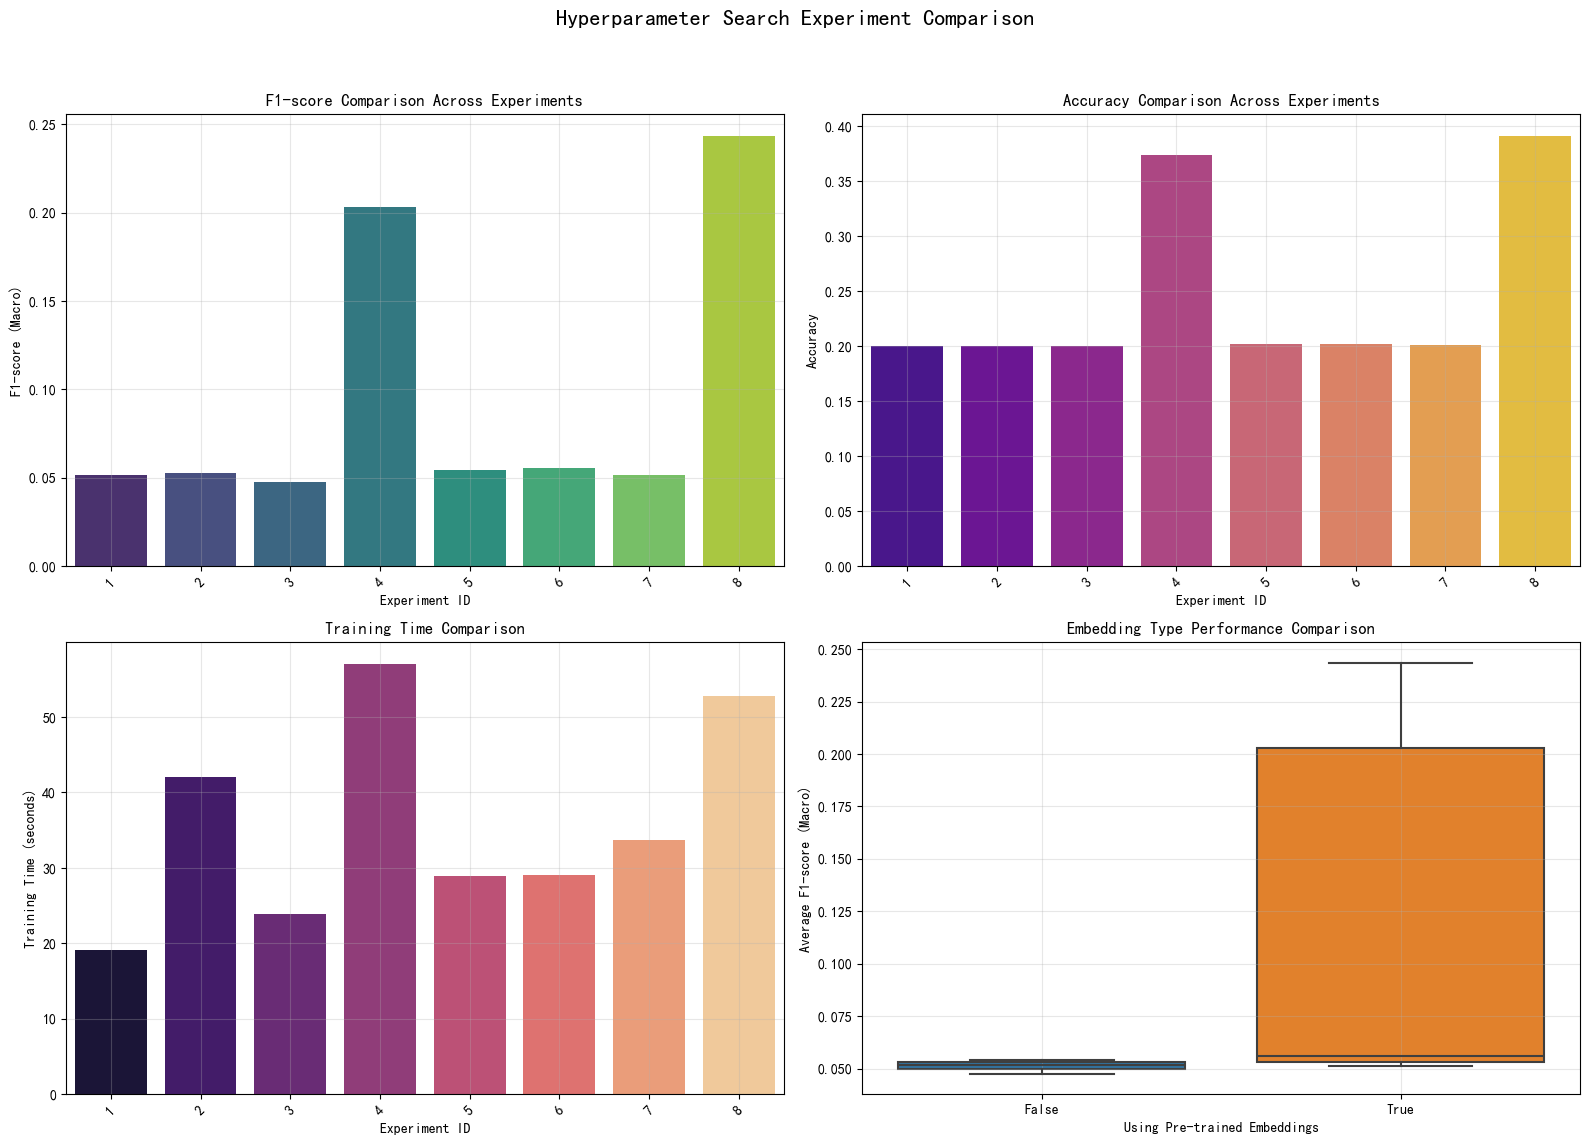


📊 Experiment comparison report generated at: experiment_comparison.csv
Best Experiment ID: 8
Best Macro F1-score: 0.2434
Best Parameters:
{
  "learning_rate": 0.001,
  "batch_size": 64,
  "dropout_rate": 0.3,
  "hidden_dim": 128,
  "n_layers": 1,
  "use_pretrained": true
}

✅ Program execution complete!


In [14]:
from pathlib import Path
import glob

def _resolve_processed_pt_path():
    """Find the processed .pt file saved by the preprocessing pipeline."""
    # Preferred default path
    preferred = Path("processed_data_multiclass") / "all_data.pt"
    if preferred.exists():
        print(f"✅ Using data file: {preferred}")
        return preferred

    # Fallback: look for any .pt file in the processed_data_multiclass/ directory
    proc_dir = Path("processed_data_multiclass")
    if proc_dir.exists():
        candidates = sorted(proc_dir.glob("*.pt"))
        if candidates:
            print(f"⚠️ 'all_data.pt' not found. Using fallback: {candidates[0]}")
            return candidates[0]
        else:
            raise FileNotFoundError("The 'processed_data_multiclass' directory exists, but no .pt files were found.")

    # Last resort: try a root-level all_data.pt file
    root_all = Path("all_data.pt")
    if root_all.exists():
        print(f"⚠️ Using data file from root directory: {root_all}")
        return root_all

    raise FileNotFoundError("Could not find the processed data file. Please ensure 'processed_data_multiclass/all_data.pt' exists.")

def main():
    """Complete demonstration workflow (for 10-class star rating)."""
    print("="*80)
    print("🤖 Sentiment Analysis System - Full Demonstration (10-Class Star Rating)")
    print("="*80)

    try:
        # Load data (points to the .pt file under processed_data_multiclass)
        print("📂 Loading data...")
        data_path = _resolve_processed_pt_path()
        data = torch.load(str(data_path))

        # Create datasets
        train_dataset = TensorDataset(
            data['train_sequences'], data['train_masks'],
            data['train_labels'], data['train_lengths']
        )
        val_dataset = TensorDataset(
            data['val_sequences'], data['val_masks'],
            data['val_labels'], data['val_lengths']
        )
        test_dataset = TensorDataset(
            data['test_sequences'], data['test_masks'],
            data['test_labels'], data['test_lengths']
        )
        
        # Calculate vocabulary size from the maximum index in the data
        vocab_size = max(
            data['train_sequences'].max().item(),
            data['val_sequences'].max().item(),
            data['test_sequences'].max().item()
        ) + 1

        print(f"Vocabulary Size: {vocab_size}")
        print(f"Training set: {len(train_dataset)} samples")
        print(f"Validation set: {len(val_dataset)} samples")
        print(f"Test set: {len(test_dataset)} samples")

        # DataLoaders
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # --- Option 1: Quick training of a single model ---
        print("\n1. 🚀 Performing quick training for a single model...")
        analyzer = SentimentAnalyzer(device=device)
        analyzer.create_model(vocab_size=vocab_size, use_pretrained=False, glove_path='./glove.6B.100d.txt')

        history = analyzer.train_model(
            train_loader, val_loader,
            learning_rate=0.001, num_epochs=10
        )

        metrics = analyzer.evaluate_model(test_loader)
        analyzer.generate_report()

        # --- Option 2: Hyperparameter search (optional) ---
        print("\n2. 🔍 Do you want to perform a hyperparameter search? (y/n)")
        user_input = input().strip().lower()

        if user_input == 'y':
            print("Starting hyperparameter search...")
            experiment_manager = ExperimentManager(device=device)

            # A smaller parameter grid for a quicker search
            quick_param_grid = {
                'learning_rate': [0.0005, 0.001],
                'batch_size': [32, 64],
                'dropout_rate': [0.3, 0.5],
                'hidden_dim': [128],
                'n_layers': [1, 2],
                'use_pretrained': [False, True]
            }

            results = experiment_manager.run_hyperparameter_search(
                train_loader, val_loader, test_loader, vocab_size,
                param_grid=quick_param_grid, max_experiments=8
            )

            experiment_manager.generate_comparison_report()
        
        else:
            print("Skipping hyperparameter search.")

        print("\n✅ Program execution complete!")

    except Exception as e:
        import traceback
        print(f"❌ An error occurred: {e}")
        traceback.print_exc()
        print("Please check the data file path and format.")

if __name__ == "__main__":
    main()